In [6]:
using Flux, Plots, Statistics, Random, ProgressMeter

┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1260
########################################################################   99.2%                                          3.6%       8.1%                                          11.6%    16.3%                                         19.5%    23.4%                                       26.6%     28.9% 30.3%                                      31.2% 32.6%                                        34.5% 36.2%                                            38.3%     39.6%                                         41.7%  43.1%                                         44.6%   47.0%                                        49.3%      51.2%###                                    53.5%     55.5%###                                  57.0% 58.7%######                               60.4% 62.1%#                             63.8%##############                          67.2%  68.8%      70.3%#####################           

######################################################################### 100.0%
#########                                                                  12.7%                                          1.8%      4.9%Excessive output truncated after 524289 bytes.                                       12.1%

In [30]:
Random.seed!(301341)

MersenneTwister(UInt32[0x0004991d], Random.DSFMT.DSFMT_state(Int32[-157111024, 1073331095, -867495699, 1073191104, 1639334311, 1073706424, -1758500981, 1073666098, 189956960, 1073687843  …  -1887146019, 1073447577, 494628161, 1073546910, 291638608, 1883496342, -415515204, 1815711982, 382, 0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], UInt128[0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000  …  0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000

In [31]:
batchsize = 128


mnist_data = Flux.Data.MNIST.images();
mnist_labels = Flux.Data.MNIST.labels();

# clean mnist data
mnist_flat = [reshape(Float32.(img), :) for img in mnist_data];

# Check to make sure you know what batchseq does
all(get.(Flux.batchseq(mnist_flat[1:10]), 4, 0) .== mnist_flat[4])


data_loader = Flux.Data.DataLoader((mnist_flat, mnist_labels), batchsize=batchsize, shuffle=true, partial=false);



In [34]:
# create rnn
x_size = 1
num_labels = 10
num_hidden = 64
learning_rate = 0.001
num_epochs = 50

rnn = Chain(LSTM(1, num_hidden), BatchNorm(64, relu), Dense(num_hidden, num_labels))
pred = (x)->softmax(rnn(x))

# create optimizer
opt = RMSProp(learning_rate)

RMSProp(0.001, 0.9, IdDict{Any,Any}())

In [42]:
ps = params(rnn)
losses = Float32[]
for epoch ∈ 1:num_epochs
    sum_ℒ = 0.0f0
    prg = Progress(length(data_loader), 1, "Epoch $(epoch): ")
    for datum ∈ data_loader
        (X, Y) = datum
        x = reshape.((Flux.batchseq(X)), 1, :)
        y = Flux.batch([Flux.onehot(Y[i], 0:9) for i in 1:batchsize])
        Flux.reset!(rnn)
        ℒ = 0.0f0        
        gs = gradient(ps) do
            ℒ = Flux.Losses.logitcrossentropy(map(rnn, x)[end], y)
            sum_ℒ += ℒ
            return ℒ
        end
#         func()
        Flux.update!(opt, ps, gs)
        next!(prg, showvalues=Dict(:ℒ => ℒ))
    end
    push!(losses, sum_ℒ)
    print("epoch: $(epoch), loss: $(sum_ℒ)")
endspark

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /home/matt/.julia/packages/ProgressMeter/poEzd/src/ProgressMeter.jl:463
Epoch 50: 100%|█████████████████████████████████████████| Time: 0:10:43
  ℒ:  0.15890133


epoch: 50, loss: 30.091131

In [37]:
length(data_loader)

468

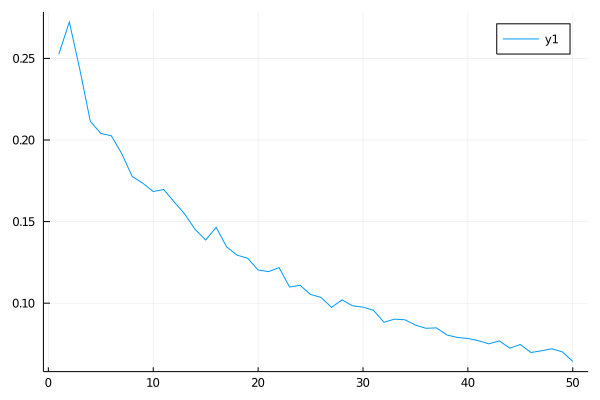

In [43]:
plot(losses./length(data_loader))

In [41]:
savefig("lstm_mnist.pdf")